# Latent representation analysis
In this notebook we analyse and compare the latent representations produced by the Wav2Vec2 feature extractor and the brain feature extractor

## Preperation

### Imports

In [17]:
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text_w_phonemes import Brain2TextWPhonemesDataset
from src.analysis.latent_analysis_util import generate_speech_multiple, generate_audio_representations, generate_brain_representations
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from src.args.yaml_config import YamlConfig
from src.analysis.latent_analysis_util import per_seq_avg_of_dimreduced_repr
from src.analysis.latent_analysis_util import flatten_square_matrix_rm_diag
yaml_config = YamlConfig().config

In [18]:
test_ds = Brain2TextWPhonemesDataset(B2TDatasetArgsModel(limit_samples=10), yaml_config, "test")
test_transcriptions = [test_ds[i].transcription for i in range(len(test_ds))]

### Generate speech for test transcriptions

### Extract test transcriptions

In [19]:
generate_speech_multiple(test_transcriptions)

10/10 audios generated (0 newly generated)



## Generate audio latent representations

In [20]:
audio_representations = generate_audio_representations(test_ds) 

10/10 audio representations generated 



## Generate brain latent representations

In [21]:
brain_representations = generate_brain_representations(test_ds)

10/10 brain representations generated 



## Perform Dimensionality reduction

In [22]:
all_data = audio_representations.non_aggregated + brain_representations.non_aggregated
all_data_np = torch.stack([rep for _, rep in all_data]).numpy()
dim_reducer = TSNE(n_components=2)
all_data_dimreduced = dim_reducer.fit_transform(all_data_np)

### Visualize audio / brain encoder clusters (no seq aggregation)

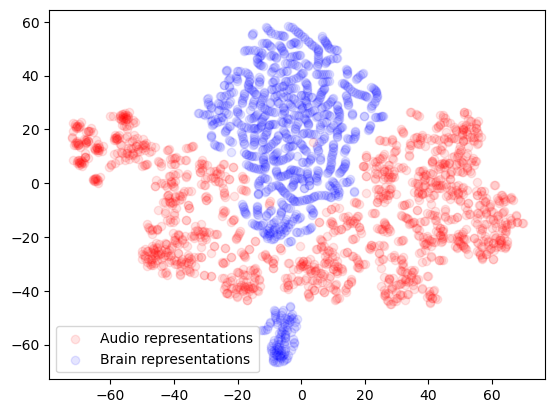

In [23]:
# Show scatter plot of all_data_pca with the first len(test_set) samples in one color and the rest in another color
plt.scatter(all_data_dimreduced[:len(audio_representations.non_aggregated), 0], all_data_dimreduced[:len(audio_representations.non_aggregated), 1], c="red", label="Audio representations", alpha=0.1)
plt.scatter(all_data_dimreduced[len(audio_representations.non_aggregated):, 0], all_data_dimreduced[len(audio_representations.non_aggregated):, 1], c="blue", label="Brain representations", alpha=0.1)
plt.legend()
plt.show()

### Visualize transcription idx clusters

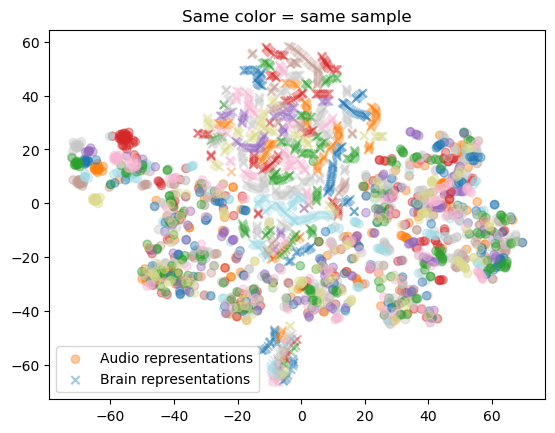

In [24]:
plt.scatter(all_data_dimreduced[:len(audio_representations.non_aggregated), 0], all_data_dimreduced[:len(audio_representations.non_aggregated), 1], c=[rep.idx for rep in audio_representations.non_aggregated], cmap="tab20", label="Audio representations", alpha=0.4) # type: ignore
plt.scatter(all_data_dimreduced[len(audio_representations.non_aggregated):, 0], all_data_dimreduced[len(audio_representations.non_aggregated):, 1], c=[rep.idx for rep in brain_representations.non_aggregated], cmap="tab20", label="Brain representations", alpha=0.4, marker='x') # type: ignore
plt.legend()
plt.title("Same color = same sample")
plt.show()


### Visualize audio / brain encoder clusters (with seq aggregation)

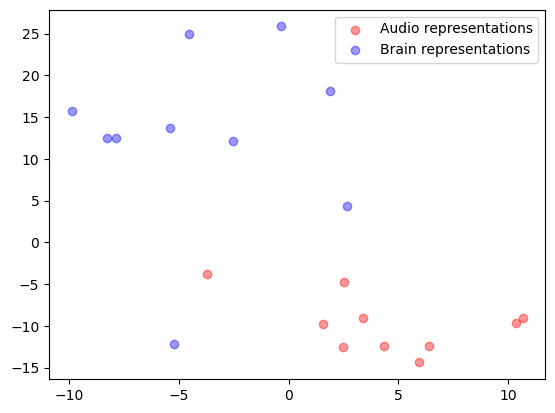

In [25]:
seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(all_data_dimreduced, all_data)
    
assert len(seq_dimreduced_avg_np) == len(test_ds) * 2, f"Expected {len(test_ds) * 2} sequences, got {len(seq_dimreduced_avg_np)}"
plt.scatter(seq_dimreduced_avg_np[:len(test_ds), 0], seq_dimreduced_avg_np[:len(test_ds), 1], c="red", label="Audio representations", alpha=0.4)
plt.scatter(seq_dimreduced_avg_np[len(test_ds):, 0], seq_dimreduced_avg_np[len(test_ds):, 1], c="blue", label="Brain representations", alpha=0.4)
plt.legend()
plt.show()

### Visualize sample pairs (brain, audio)

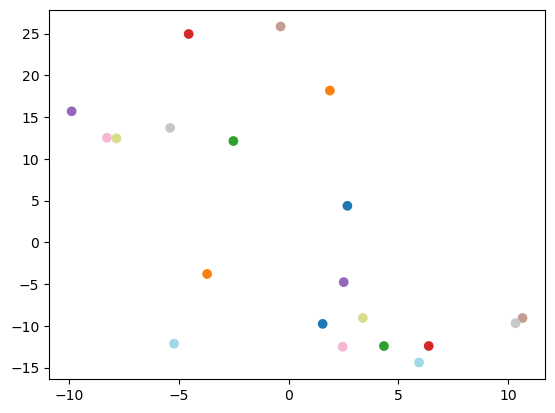

In [26]:
# Show scatter plot with each index modulo len(test_set) in one color

plt.scatter(seq_dimreduced_avg_np[:, 0], seq_dimreduced_avg_np[:, 1], c=[i % len(test_ds) for i in range(len(seq_dimreduced_avg_np))], cmap="tab20") #type: ignore

## Distance between dimensionality reduced audio and brain representation pairs

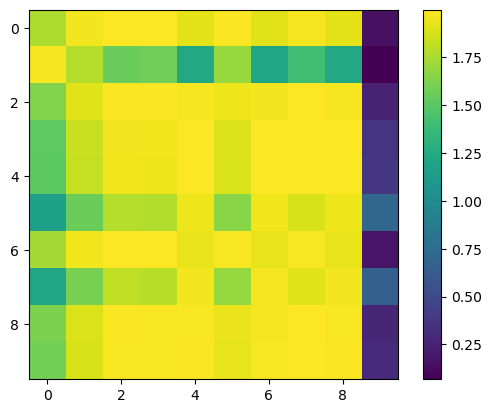

In [27]:
# Show distance matrix between dimensionality reduced audio and brain representation pairs
from scipy.spatial.distance import cdist

dimreduced_distances = cdist(seq_dimreduced_avg_np[:len(test_ds)], seq_dimreduced_avg_np[len(test_ds):],'cosine')
plt.imshow(dimreduced_distances)
plt.colorbar()

## Transcription phoneme distance matrix

100% of distances calculated 

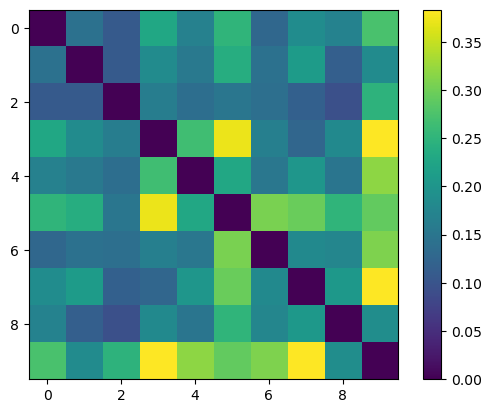

In [28]:
from scipy import spatial
from src.util.phoneme_helper import PHONE_DEF_SIL

test_phonemes = [test_ds[i].phonemes for i in range(len(test_ds))]

def get_phoneme_count_vec(phonemes: list[str]):
    phoneme_count = np.zeros(len(PHONE_DEF_SIL))
    for phoneme in phonemes:
        index = PHONE_DEF_SIL.index(phoneme)
        assert index != -1, f"Phoneme {phoneme} not found in phoneme list"
        phoneme_count[index] += 1
    return phoneme_count

label_distances = np.zeros((len(test_phonemes), len(test_phonemes)))
for i in range(len(test_phonemes)):
    p_count = get_phoneme_count_vec(test_phonemes[i])
    for j in range(len(test_phonemes)):
        label_distances[i][j] = spatial.distance.cosine(p_count, get_phoneme_count_vec(test_phonemes[j]))
    print(f"\r{int(((i+1)/len(test_transcriptions))*100)}% of distances calculated ", end="")
plt.imshow(label_distances, interpolation="nearest")
plt.colorbar()

### Relationship between transcription phoneme distance and dim reduced representation pairs distance

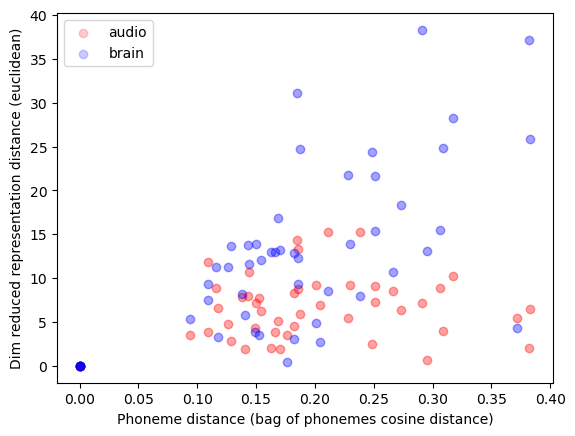

In [29]:
plt.scatter(label_distances.flatten(), cdist(seq_dimreduced_avg_np[:len(test_ds)], seq_dimreduced_avg_np[:len(test_ds)]).flatten(), alpha=0.2, c="red", label="audio")
plt.scatter(label_distances.flatten(), cdist(seq_dimreduced_avg_np[len(test_ds):], seq_dimreduced_avg_np[len(test_ds):]).flatten(), alpha=0.2, c="blue", label="brain")
plt.xlabel("Phoneme distance (bag of phonemes cosine distance)")
plt.ylabel("Dim reduced representation distance (euclidean)")
plt.legend()
plt.show()

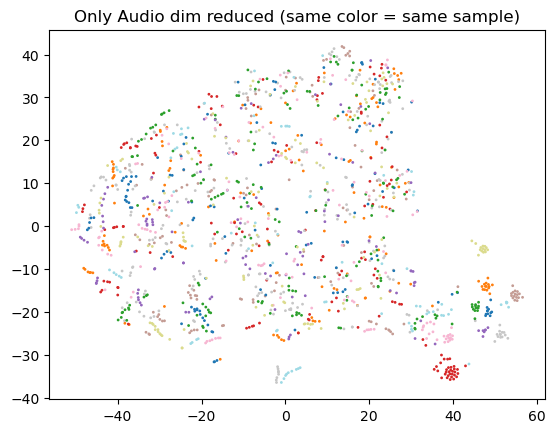

In [30]:
audio_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
audio_data_dimreduced = audio_only_dimreducer.fit_transform(np.array([rep.numpy() for _, rep in audio_representations.non_aggregated]))
plt.scatter(audio_data_dimreduced[:, 0], audio_data_dimreduced[:, 1], c=[rep.idx for rep in audio_representations.non_aggregated], cmap="tab20", label="Audio representations", s=1) # type: ignore
plt.title("Only Audio dim reduced (same color = same sample)")
plt.show()

### Audio only per seq averaged pairwise phoneme similarity <> distance relation

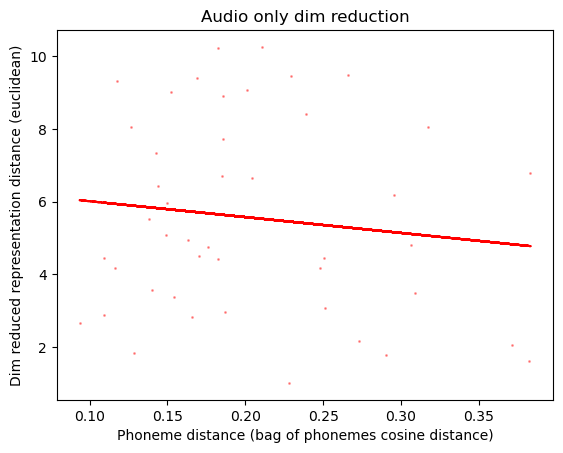

In [31]:
audio_seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(audio_data_dimreduced, audio_representations.non_aggregated)
labels_flattend_nodiag = flatten_square_matrix_rm_diag(label_distances)
audio_repr_distances_flattened_nodiag = flatten_square_matrix_rm_diag(cdist(audio_seq_dimreduced_avg_np, audio_seq_dimreduced_avg_np))


plt.scatter(labels_flattend_nodiag, audio_repr_distances_flattened_nodiag, alpha=0.2, c="red", label="audio", s=1)
plt.xlabel("Phoneme distance (bag of phonemes cosine distance)")
plt.ylabel("Dim reduced representation distance (euclidean)")
plt.title("Audio only dim reduction")


z = np.polyfit(labels_flattend_nodiag, audio_repr_distances_flattened_nodiag, 1)
p = np.poly1d(z)
plt.plot(labels_flattend_nodiag, p(labels_flattend_nodiag), "r--")

plt.show()

### Audio only non aggregated pairwise phoneme similarity <> distance relation

100% of distances calculated 

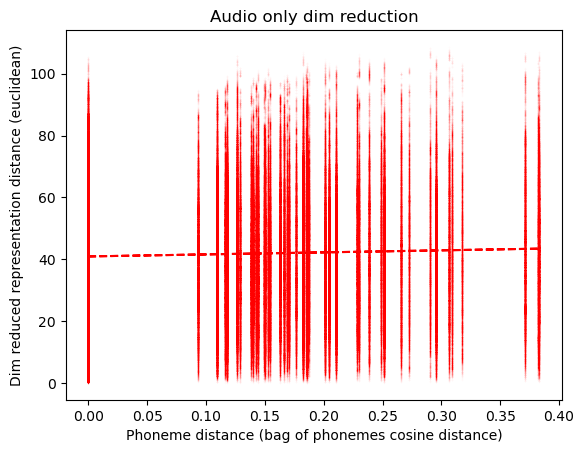

In [38]:
label_distances_nonaggregated = np.zeros((len(audio_data_dimreduced), len(audio_data_dimreduced)))

for i in range(len(audio_data_dimreduced)):
    i_sample = audio_representations.non_aggregated[i]
    for j in range(len(audio_data_dimreduced)):
        j_sample = audio_representations.non_aggregated[j]
        label_distances_nonaggregated[i][j] = label_distances[i_sample.idx][j_sample.idx]
    print(f"\r{int(((i+1)/len(audio_data_dimreduced))*100)}% of distances calculated ", end="")

labels_nonagg_flattend_nodiag = flatten_square_matrix_rm_diag(label_distances_nonaggregated)
audio_repr_distances_flattened_nodiag = flatten_square_matrix_rm_diag(cdist(audio_data_dimreduced, audio_data_dimreduced))


plt.scatter(labels_nonagg_flattend_nodiag, audio_repr_distances_flattened_nodiag, alpha=0.005, c="red", label="audio", s=1)
plt.xlabel("Phoneme distance (bag of phonemes cosine distance)")
plt.ylabel("Dim reduced representation distance (euclidean)")
plt.title("Audio only dim reduction")


z = np.polyfit(labels_nonagg_flattend_nodiag, audio_repr_distances_flattened_nodiag, 1)
p = np.poly1d(z)
plt.plot(labels_nonagg_flattend_nodiag, p(labels_nonagg_flattend_nodiag), "r--")

plt.show()

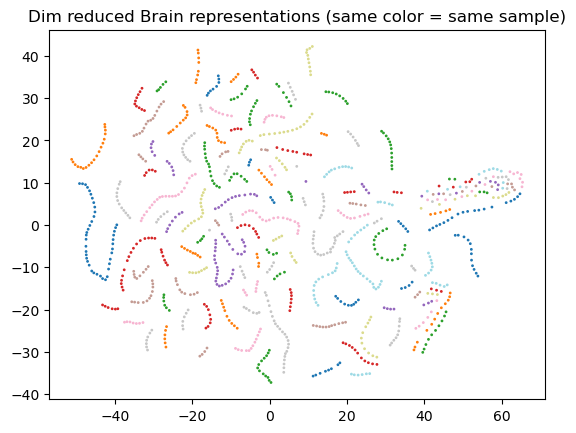

In [33]:
brain_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
brain_data_dimreduced = brain_only_dimreducer.fit_transform(np.array([rep.numpy() for _, rep in brain_representations.non_aggregated]))
plt.scatter(brain_data_dimreduced[:, 0], brain_data_dimreduced[:, 1], c=[rep.idx for rep in brain_representations.non_aggregated], cmap="tab20", label="Brain representations", s=1) # type: ignore
plt.title("Dim reduced Brain representations (same color = same sample)")
plt.show()

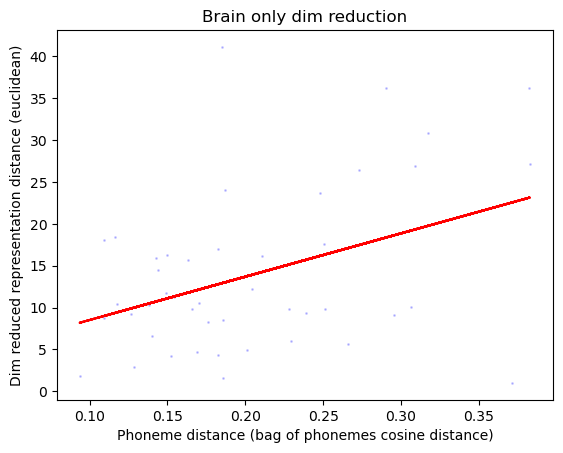

In [34]:
brain_seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(brain_data_dimreduced, brain_representations.non_aggregated)

labels_flattend_nodiag = flatten_square_matrix_rm_diag(label_distances)
brain_repr_distances_flattened_nodiag = flatten_square_matrix_rm_diag(cdist(brain_seq_dimreduced_avg_np, brain_seq_dimreduced_avg_np))

plt.scatter(labels_flattend_nodiag, brain_repr_distances_flattened_nodiag, alpha=0.1, c="blue", label="brain", s=1)
plt.xlabel("Phoneme distance (bag of phonemes cosine distance)")
plt.ylabel("Dim reduced representation distance (euclidean)")
plt.title("Brain only dim reduction")
#plt.legend()

# Add regression line
z = np.polyfit(labels_flattend_nodiag, brain_repr_distances_flattened_nodiag, 1)
p = np.poly1d(z)
plt.plot(labels_flattend_nodiag, p(labels_flattend_nodiag), "r--")

plt.show()